In [473]:
import os

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn

from sklearn.model_selection import KFold

In [474]:
# Validation hyperparameters
n_folds = 5
n_samples_per_fold = 200
n_samples_total = n_folds * n_samples_per_fold    # 1000
n_epochs = 30
batch_size = 20
learning_rate = 3e-4

# Data parameters
input_length = 500               # Each sample is a vector of input_length timestamps
input_crop_length = input_length # What length to crop the sample to
target_length = 2                # Model should predict just two parameters: zeta and w_n

# Useful files
validation_files = [f"cross_validation_fold{i}.csv" for i in range(1, n_folds + 1)]
test_file = "test_data.csv"

In [475]:
class SecondOrderDataset(Dataset):
    """ Second-Order System Dataset"""
    
    def __init__(self, csv_file_prefix, nfolds, root_dir = '.', transform=None):
        """
        Args:
            csv_file_prefix (string): common prefix for all files we want to read in
            nfolds (int): number of folds
            root_dir (string): Directory containing files we want to read
            transform (callable, optional): Transofrm to be applied on a sample
        """
        
        # Load in all validation datasets and merge into a Pandas dataframe
        self.validation_data_csv = list()
        
        for fold in range(1, 1 + nfolds):
            csv_file = csv_file_prefix + str(fold) + ".csv"
            csv_path = os.path.join(root_dir, csv_file)
                
            csv_data = pd.read_csv(csv_path).to_numpy()
            self.validation_data_csv.append(csv_data)
            
        self.validation_data = np.vstack(tuple(self.validation_data_csv))
        mean = np.mean(self.validation_data[:,0:2], axis = 0)
        mean_sub = self.validation_data[:,0:2] - mean
        
        stddev = np.std(self.validation_data[:,0:2], axis = 0)
        stddev_rem = mean_sub / stddev
        self.validation_data[:, 0:2] = stddev_rem
        
        self.transform = transform
    
    def __len__(self):
        return self.validation_data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        targets = self.validation_data[idx, 0:2]
        inputs = self.validation_data[idx, 2:]
        
        # assert that we have 500 samples for each data point
        assert inputs.shape[-1] == input_length
        
        sample = {'targets':targets, 'inputs':inputs}
        
        # convert to tensor, clip signal, etc.
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    

(zeta, wn) = [-1.47408695 -0.31183152], inputs = <class 'numpy.ndarray'>




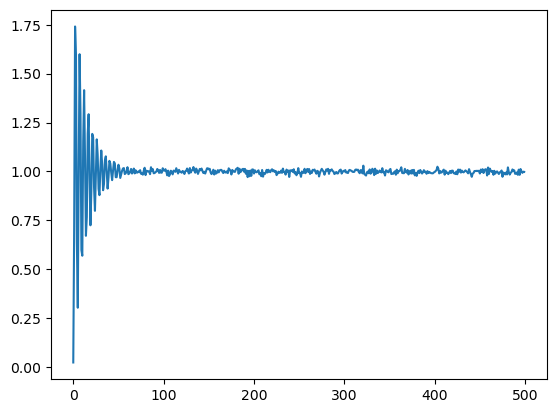

(zeta, wn) = [-0.95382097 -0.17323973], inputs = <class 'numpy.ndarray'>




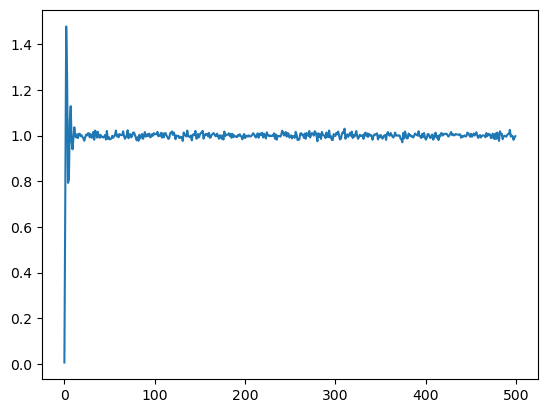

(zeta, wn) = [-0.60697698 -0.38112741], inputs = <class 'numpy.ndarray'>




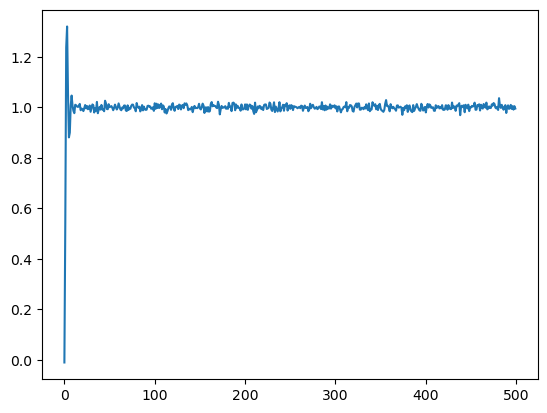

(zeta, wn) = [-1.47408695  1.35126991], inputs = <class 'numpy.ndarray'>




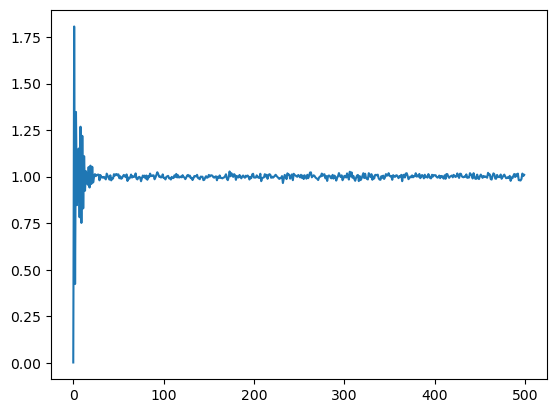

(zeta, wn) = [0.43355498 1.28197402], inputs = <class 'numpy.ndarray'>




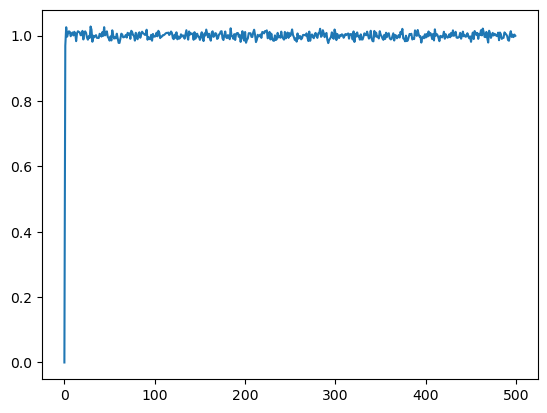

In [476]:
# Verify that dataset was loaded properly
second_order_dataset = SecondOrderDataset(csv_file_prefix="cross_validation_fold",
                                          nfolds = 5)

for i in range(len(second_order_dataset)):
    sample = second_order_dataset[i * n_samples_per_fold]
    
    print(f"(zeta, wn) = {sample['targets']}, inputs = {type(sample['inputs'])}\n\n")
    plt.figure()
    plt.plot(sample['inputs'])
    plt.show()
    if i == n_folds - 1:

        break
        

In [477]:
# Define ToTensor transformation
class ToTensor(object):
    """ Convert ndarrays in sample to Tensors"""
    
    def __call__(self, sample):
        targets, inputs = sample.values()
        return{'targets': torch.from_numpy(targets).float(),
               'inputs': torch.from_numpy(inputs).float()}
    
class CropTo(object):
    """ Crop input tensor"""
    
    def __init__(self, cropTo):
        self.cropTo = cropTo
        
    def __call__(self, sample):
        targets, inputs = sample.values()
        return{'targets': targets,
               'inputs': inputs[0:self.cropTo]}

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



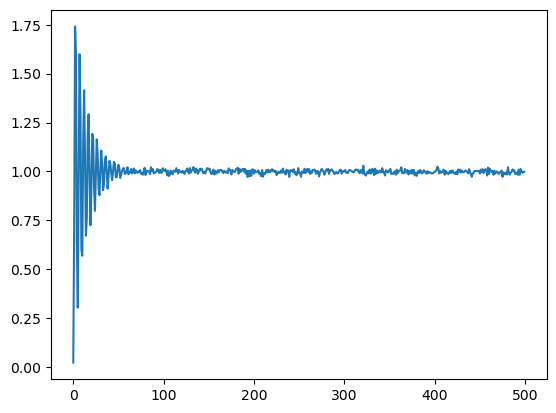

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



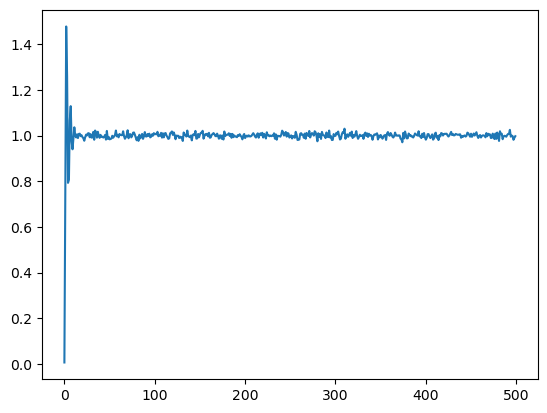

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



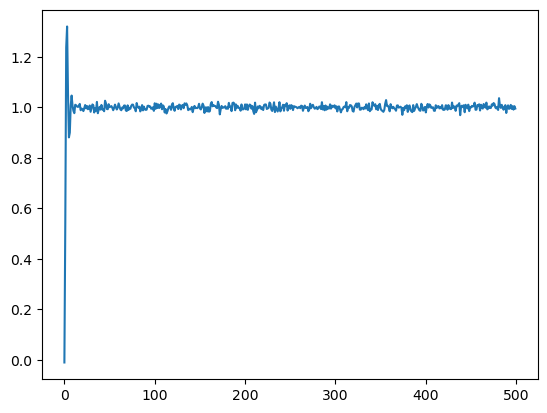

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



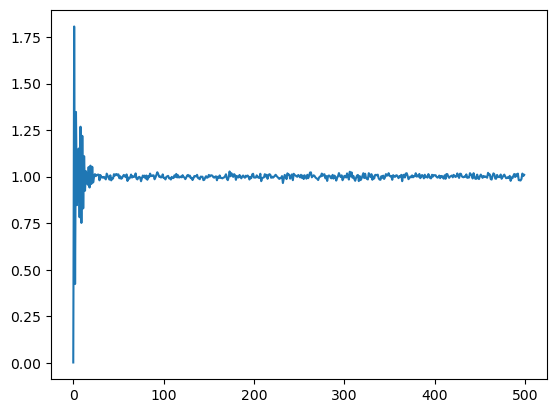

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



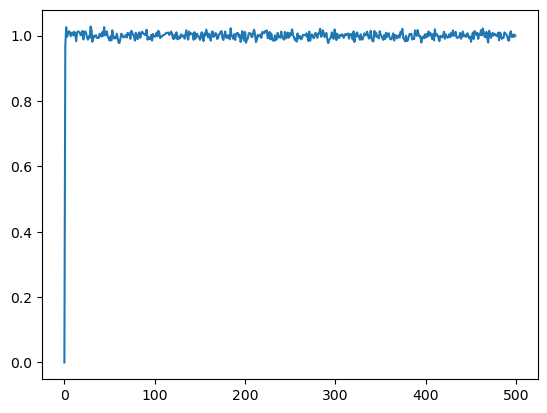

In [478]:
# Verify that dataset can be loaded as a Tensor and cropped
tsfrm = transforms.Compose([ToTensor(), CropTo(input_crop_length)])
second_order_dataset = SecondOrderDataset(csv_file_prefix="cross_validation_fold",
                                          nfolds = 5,
                                          transform=tsfrm)

for i in range(len(second_order_dataset)):
    
    sample = second_order_dataset[i * n_samples_per_fold]
    
    print(f"type(zeta, wn) = {type(sample['targets'])}, inputs = {type(sample['inputs'])}\n")

    plt.figure()
    plt.plot(sample['inputs'].numpy())
    plt.show()
    if i == n_folds - 1: break

In [479]:
# Use sklearn.KFold to split the dataset into 5 folds for cross-validation
kfold = KFold(n_splits=n_folds, shuffle=False)

for fold, (train_idx, test_idx) in enumerate(kfold.split(second_order_dataset)):
    print(f"Fold {fold}:")
    
    targets, inputs = second_order_dataset[test_idx[0]].values()
    print(f"\tFirst target: {targets.numpy()}, first input: {inputs.numpy().shape}")
    
    targets, inputs = second_order_dataset[test_idx[-1]].values()
    print(f"\tLast target: {targets.numpy()}, last input: {inputs.numpy().shape}\n")

Fold 0:
	First target: [-1.474087  -0.3118315], first input: (500,)
	Last target: [ 0.95382094 -0.5197192 ], last input: (500,)

Fold 1:
	First target: [-0.95382094 -0.17323974], first input: (500,)
	Last target: [-0.78039896 -0.3118315 ], last input: (500,)

Fold 2:
	First target: [-0.606977   -0.38112742], first input: (500,)
	Last target: [0.78039896 1.0740863 ], last input: (500,)

Fold 3:
	First target: [-1.474087  1.35127 ], first input: (500,)
	Last target: [-0.95382094  0.58901507], last input: (500,)

Fold 4:
	First target: [0.43355498 1.2819741 ], first input: (500,)
	Last target: [ 0.78039896 -1.6284535 ], last input: (500,)



In [480]:
# Set up neural network module
torch.manual_seed(42)
class NeuralNetwork(nn.Module):
    """
    Simple neural network
    """
    
    def __init__(self, input_dim = input_crop_length, hidden_dim = 50, output_dim = target_length, num_layers = 3, loss_fn = nn.MSELoss(), dropout = None):
        super().__init__()
        
        self.loss_fn = loss_fn
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
#         self.linears = nn.ModuleList([nn.Linear(self.input_dim, self.hidden_dim),
#                                      nn.Linear(self.hidden_dim, self.hidden_dim),
#                                      nn.Linear(self.hidden_dim, self.output_dim)])
        
        self.ReLU = nn.LeakyReLU(0.1)
        # ModuleList seems to spit out junk values, not sure why, so
        # I'll explicitly create linear layers instead
        self.layers = nn.Sequential(
                                    nn.Linear(self.input_dim, self.hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim, self.hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim, self.output_dim)
                                    )
        

        
        self.dropout = nn.dropout(dropout) if dropout is not None else None
        
        #self.reset_parameters()
        
    def forward(self, x):
        x = self.layers(x)

        return x
            
    def reset_parameters(self):
        for i, layer in enumerate(self.linears.children()):
            nn.init.uniform_(layer.weight)
            #print(f"Layer {i + 1} weights: {layer.weight}")


Fold 0
---------------------------------


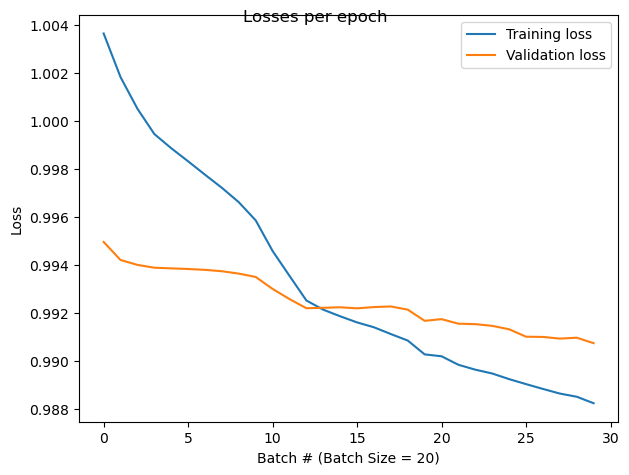


Fold 1
---------------------------------


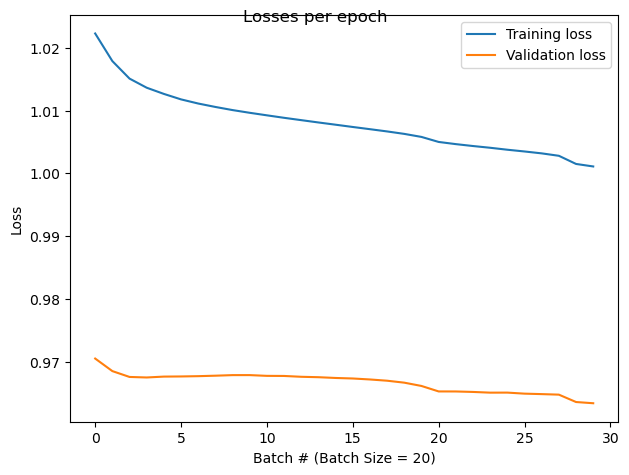


Fold 2
---------------------------------


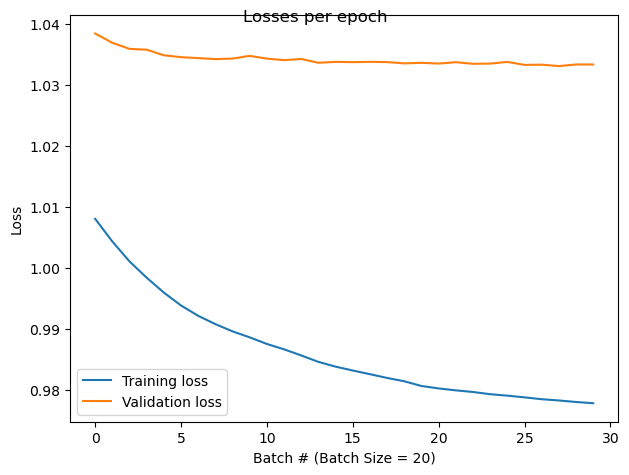


Fold 3
---------------------------------


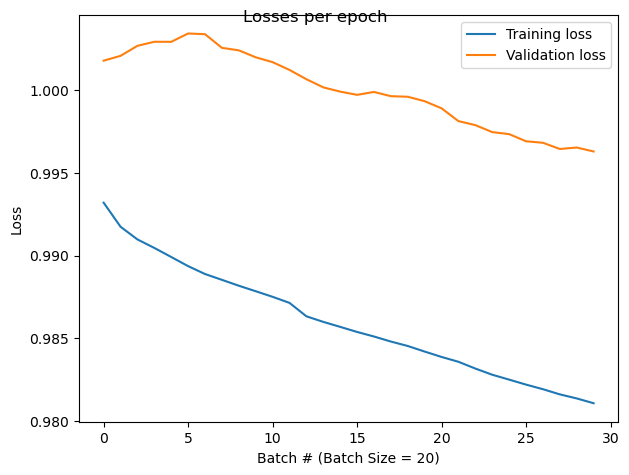


Fold 4
---------------------------------


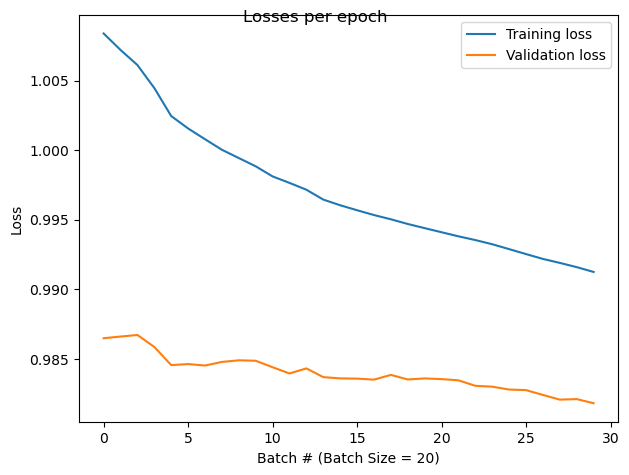

In [481]:
# Perform validation
tsfrm = transforms.Compose([ToTensor(), CropTo(input_crop_length)])
second_order_dataset = SecondOrderDataset(csv_file_prefix="cross_validation_fold",
                                          nfolds = 5,
                                          transform=tsfrm)

for fold, (train_idx, test_idx) in enumerate(kfold.split(second_order_dataset)):
    
    print(f"\nFold {fold}")
    print("---------------------------------")
    
    # Sample elements from train and test sets WITHOUT replacement
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
    
    # Define data loaders for train and test sets
    trainloader = torch.utils.data.DataLoader(second_order_dataset,
                                              batch_size=batch_size,
                                              sampler = train_subsampler)
    trainlossloader = torch.utils.data.DataLoader(second_order_dataset,
                                                  batch_size=len(train_idx),
                                                  sampler = train_subsampler)
    
    testloader = torch.utils.data.DataLoader(second_order_dataset,
                                             batch_size=n_samples_per_fold,
                                             sampler = test_subsampler)
    
    model = NeuralNetwork()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    plt.figure()
    plt.suptitle("Losses per epoch")
    
    train_losses = []
    valid_losses = []
    for epoch in range(0, n_epochs):
        
        #print(f'Starting epoch {epoch+1}')
        
        # optimize over all batches in epoch
        for i, data in enumerate(trainloader, 0):
            targets, inputs = data.values()
            out = model(inputs)
            loss = model.loss_fn(out, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # see how model performs on training dataset after epoch  
        with torch.no_grad():
            for i, data in enumerate(trainlossloader, 0):
                targets, inputs = data.values()
                out = model(inputs)
                loss = model.loss_fn(out, targets)
                train_losses.append(loss.item())
            
        # see how model performs on validation data
        with torch.no_grad():
            error = 0.0
            for i, data in enumerate(testloader,0):
                targets, inputs = data.values()
                out = model(inputs)
                loss = model.loss_fn(out, targets)
                valid_losses.append(loss.item())
         
    plt.plot(train_losses, label=f"Training loss")  
    plt.plot(valid_losses, label=f"Validation loss")
    plt.xlabel(f"Batch # (Batch Size = {batch_size})")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
for i, data in enumerate(testloader,0):
    targets, inputs = data.values()
    out = model(inputs)
    
    target_df = pd.DataFrame(targets.numpy())
    out_df = pd.DataFrame(out.detach().numpy())
    
    #target_df.to_csv('target_df.csv')
    #out_df.to_csv('out_df.csv')